# Difference in Air Quality in Days and Nights in an Italian City

##### <b>Group 11:</b> Karan Anand (60276771), Ayesha Halim (54374517), Prajna Shreedar (60202520), and Fangzhou Ye (72990732)

## 1. Introduction

Air pollution is one of the leading causes of health problems. Measuring air quality in urban areas is important for regulating outdoor activities and preserving a healthy lifestyle. Air quality is measured through sensors that detect pollutants/particles in the air. Based on this detection, air quality is placed on an index that ranges from 0 ("good") to 500 ("hazardous") (Lemeš, 2018). On a daily basis, the air quality varies with surges in activities that induce more air pollution, such as intense traffic during rush hour (Trozzi et al., 1999). 

This begs us to ask the question: **How do the summarized sensor responses used to determine air quality index differ between day and night in an Italian city from 2004 to 2005?**

For our research, we use the dataset <a href="https://archive.ics.uci.edu/dataset/360/air+quality">Air Quality</a> from the UCI machine learning repository, which we have stored in a separate GitHub repository. It contains responses to gas and particle sensors placed in a highly polluted area of an Italian city. This data was collected from 2004-2005 and depicts 9348 observations of hourly averaged concentrations of different chemical air pollutants. For the purpose of our research, we are taking readings from one month and removing cases with missing data. Our variables of interest are the ```date```, ```time```, and hourly averaged sensor response columns of ``` PT08.S1``` (carbon monoxide), ```PT08.S2``` (non-metallic hydrocarbons), ``` PT08.S3``` (NO<sub>x</sub>), ```PT08.S4``` (NO<sub>2</sub>), and ```PT08.S5``` (O<sub>3</sub>). Using sensor response variables, we will create an AQI estimator that is analogous to the true AQI but isn't bound by the range of 0 to 500. We will find the differences in the means and medians of the AQI estimators for an enhanced understanding of variability in air quality.

## 2. Preliminary Results

### 2.1. Loading the relevant libraries

In [1]:
library(tidyverse)    # metapackage used to load, clean, tidy and visualize data    
library(lubridate)    # to parse through dates and times
library(broom)        # to convert output into tidy tibbles
library(infer)        # to use the infer workflow for bootstrapping
library(gridExtra)    # to print the plots side by side

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2.2. Reading the dataset from the web

Using the ```read.csv()``` function, we read our data from the web:

In [2]:
# Set the seed to ensure consistency and reproducibility of random results
set.seed(1111)

# URL of the raw CSV file on GitHub
url <- "https://raw.githubusercontent.com/anandkaranubc/aqi_dataset/main/AirQualityUCI.csv"

# Read the dataset from the web into R
air_quality <- read.csv(url, sep = ";", header = TRUE, na.strings = "-200")

# View the first few rows of the dataset
head(air_quality)


,Date,Time,CO.GT.,PT08.S1.CO.,NMHC.GT.,C6H6.GT.,PT08.S2.NMHC.,NOx.GT.,PT08.S3.NOx.,NO2.GT.,PT08.S4.NO2.,PT08.S5.O3.,T,RH,AH,X,X.1
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>
1,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578",NA,NA
2,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255",NA,NA
3,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502",NA,NA
4,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867",NA,NA
5,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888",NA,NA
6,10/03/2004,23.00.00,"1,2",1197,38,"4,7",750,89,1337,96,1393,949,"11,2","59,2","0,7848",NA,NA


<p style="text-align: center;"><b><i>Table 1:</b> Raw Dataset</i></p>

Our dataset contains columns for date, time, chemical sensor measurements and their corresponding hourly averaged responses, temperature, relative and absolute humidity, along with some unwanted information. Moreover, since this is a European dataset, the double values (stored as characters) contain a comma instead of a decimal point.

### 2.3 Cleaning and wrangling the data into a tidy format

We clean and wrangle the data by renaming the columns to more readable and descriptive labels, and refactoring the necessary data to its proper formatting. We filter the data to only include sensor responses from March 10, 2004, to April 9, 2004; this is to minimize the number of data points we are analyzing while still yielding accurate results.

In [3]:
set.seed(1111)

# Clean the data: Convert commas to dots for numeric columns, remove unwanted columns (X, X.1), and remove NA columns
air_quality_cleaned <- air_quality |>
  mutate_at(vars(-Date, -Time), ~as.numeric(gsub(",", ".", .))) |>
  select(-X, -X.1)

# Convert Date and Time columns to proper formats
air_quality_cleaned$Date <- as.Date(air_quality_cleaned$Date, format = "%d/%m/%Y")
air_quality_cleaned$Time <- as.POSIXct(air_quality_cleaned$Time, format = "%H.%M.%S")

# Filter dataset to only include one month's worth of observations
air_quality_cleaned <- air_quality_cleaned %>%
    filter(Date >= '2004-03-10' & Date <= '2004-04-09')

# Rename the column names to more descriptive names
col_names <- c("Date", "Time", "CO_Concentration", "PT08_S1_CO_Sensor", "NMHC_Concentration",
               "C6H6_Concentration", "PT08_S2_NMHC_Sensor", "NOx_Concentration", "PT08_S3_NOx_Sensor",
               "NO2_Concentration", "PT08_S4_NO2_Sensor", "PT08_S5_O3_Sensor", "Temperature", "Relative_Humidity", "Absolute_Humidity")
colnames(air_quality_cleaned) <- col_names

In [4]:
# View the cleaned dataset for a better grasp of how our data is structured
head(air_quality_cleaned)

,Date,Time,CO_Concentration,PT08_S1_CO_Sensor,NMHC_Concentration,C6H6_Concentration,PT08_S2_NMHC_Sensor,NOx_Concentration,PT08_S3_NOx_Sensor,NO2_Concentration,PT08_S4_NO2_Sensor,PT08_S5_O3_Sensor,Temperature,Relative_Humidity,Absolute_Humidity
,<date>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2004-03-10,2023-08-13 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2,2004-03-10,2023-08-13 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
3,2004-03-10,2023-08-13 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
4,2004-03-10,2023-08-13 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
5,2004-03-10,2023-08-13 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
6,2004-03-10,2023-08-13 23:00:00,1.2,1197,38,4.7,750,89,1337,96,1393,949,11.2,59.2,0.7848


<p style="text-align: center;"><b><i>Table 2:</b> Tidy Dataset</i></p>

Our dataset is clean, tidy, and reformatted to include variables and observations of concern to our research.

### 2.4 Plotting relevant data

We plot data relevant to our research, starting with the hourly averaged sensor response, using ```ggplot2``` (from the ```tidyverse``` metapackage) and plotting functions (```ggplot()``` and ```geom_histogram()```) to create histograms for the different sensors. We also utilize ```facet_wrap``` to separate the different plots per sensor.

Warning message:
“Removed 135 rows containing non-finite values (stat_bin).”


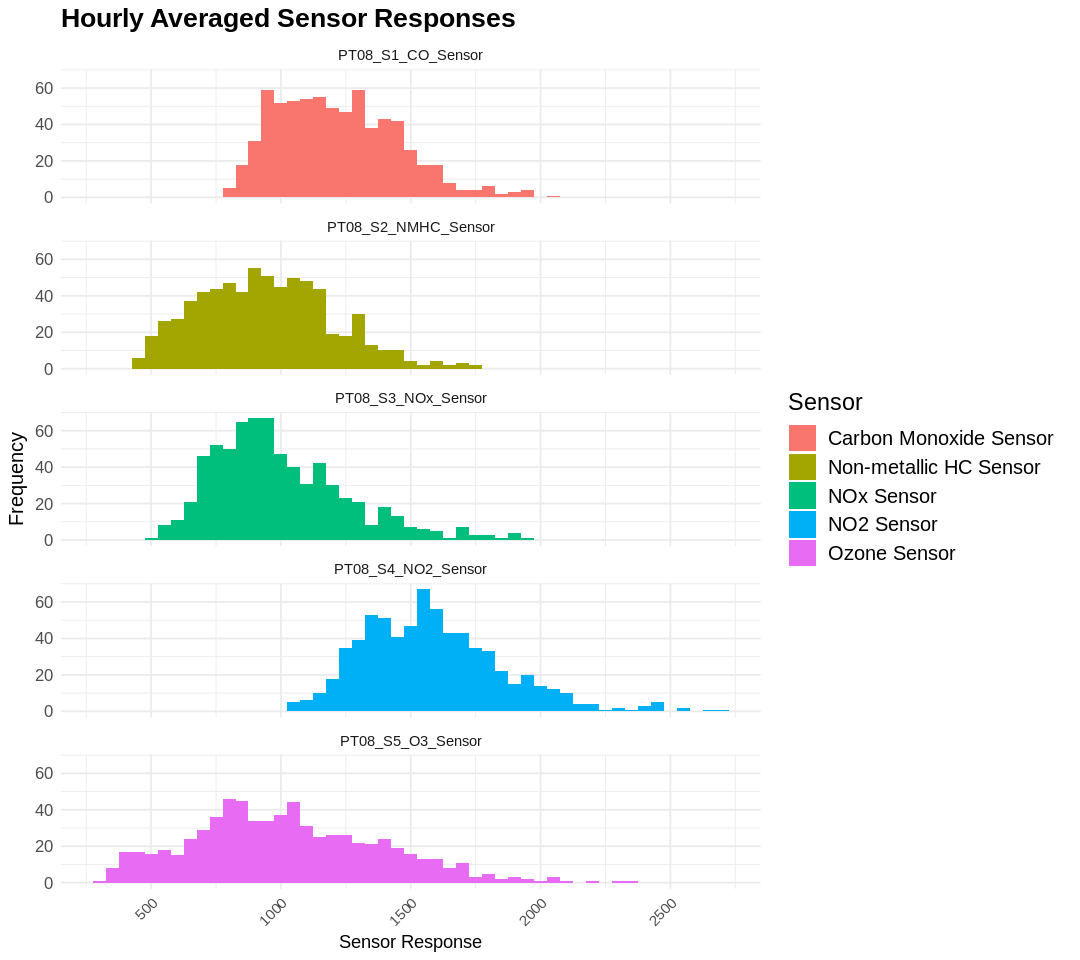

In [5]:
set.seed(1111)

options(repr.plot.width = 9, repr.plot.height = 8)

# Pivot the data to long format for ggplot
air_quality_melted <- pivot_longer(air_quality_cleaned, 
                                   cols = starts_with("PT08_S"), 
                                   names_to = "Sensor",
                                   values_to = "Sensor_Response")

# Create the plot
air_quality_sensor_plots <- ggplot(air_quality_melted, aes(x = Sensor_Response, fill = Sensor)) +
  geom_histogram(binwidth = 50, position = "dodge") +
  labs(title = "Hourly Averaged Sensor Responses",
       x = "Sensor Response",
       y = "Frequency",
       fill = "Sensor") +
  scale_fill_discrete(labels=c("Carbon Monoxide Sensor", "Non-metallic HC Sensor", "NOx Sensor", "NO2 Sensor", "Ozone Sensor")) +  
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10),               # Adjust the size of y-axis labels
    axis.title.y = element_text(size = 12),              # Adjust the size of y-axis title
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.position = "right"
  ) +
  scale_x_continuous(breaks = seq(0, 2500, by = 500))    # Adjust the x-axis tick marks

# Separate plots for each sensor using facets
air_quality_sensor_plots_faceted <- air_quality_sensor_plots + 
  facet_wrap(~ Sensor, nrow = 5)

air_quality_sensor_plots_faceted

<p style="text-align: center;"><b><i>Plot 1:</b> Histograms of Hourly Averaged Sensor Responses</i></p>

We continue plotting the hourly averaged sensor response using ```ggplot``` and ```geom_boxplot``` to create a boxplot to represent the same sensor data in a different format for better interpretation.

Warning message:
“Removed 135 rows containing non-finite values (stat_boxplot).”


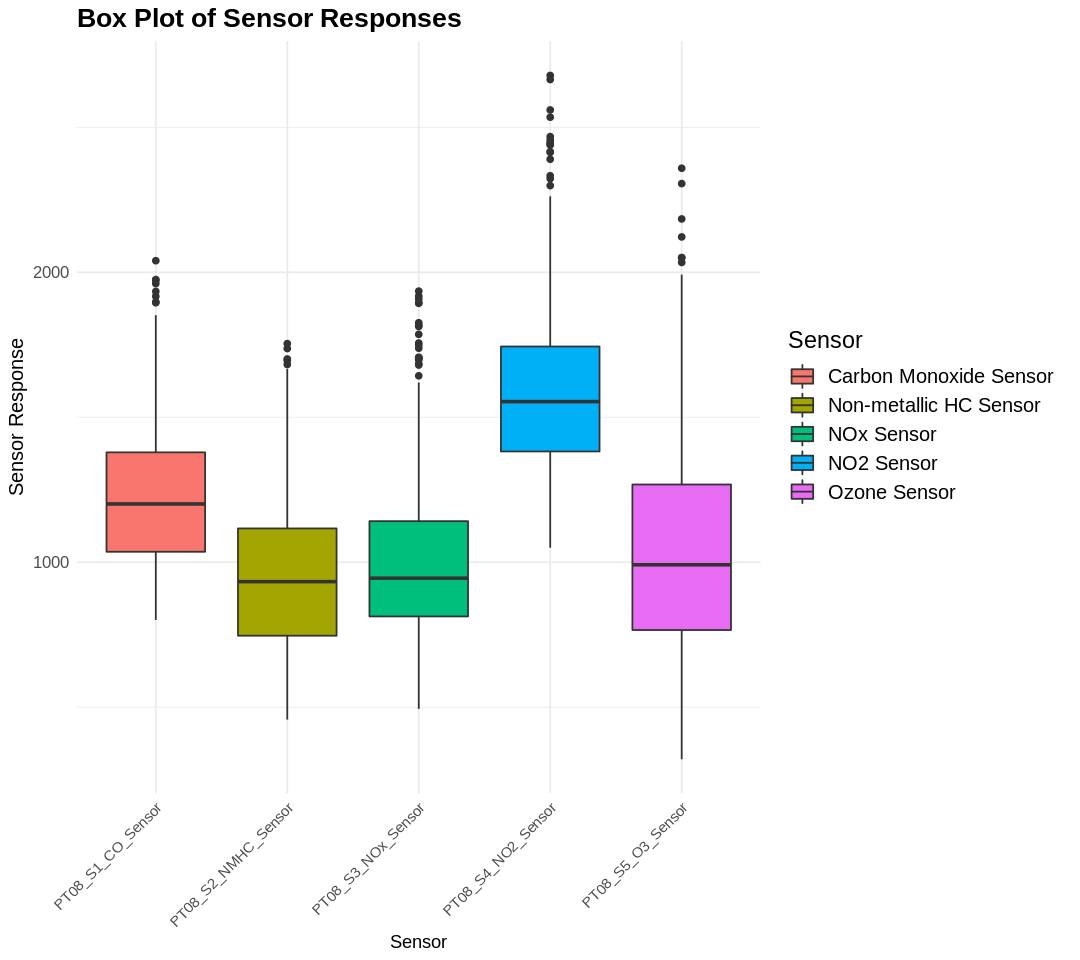

In [6]:
set.seed(1111)

# Create the box plot
air_quality_boxplot <- ggplot(air_quality_melted, aes(x = Sensor, y = Sensor_Response, fill = Sensor)) +
  geom_boxplot() +
  labs(title = "Box Plot of Sensor Responses",
       x = "Sensor",
       y = "Sensor Response",
       fill = "Sensor") +
  scale_fill_discrete(labels = c("Carbon Monoxide Sensor", "Non-metallic HC Sensor", "NOx Sensor", "NO2 Sensor", "Ozone Sensor")) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10),               # Adjust the size of y-axis labels
    axis.title.y = element_text(size = 12),              # Adjust the size of y-axis title
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.position = "right"
  )

# Print the box plot
print(air_quality_boxplot)

<p style="text-align: center;"><b><i>Plot 2:</b> Boxplots of Hourly Averaged Sensor Responses</i></p>

From our visualizations, we can see that NO2 has the highest median sensor response, followed by CO, and then O3. NOx and NMHC are approximately on par with each other, with NOx's median sensor response lying slightly above NMHC. This gives us an understanding of the concentrations of each of these chemical air pollutants.

We create a dataset of the sensor responses, grouped by the different chemical sensor. This dataset displays the summary statistics of each sensor.

In [7]:
set.seed(1111)

# Group the data by "Sensor" and calculate summary statistics
sensor_summary <- air_quality_melted %>%
  group_by(Sensor) %>%
  summarize(
    Mean_Sensor_Response = mean(Sensor_Response, na.rm = TRUE),
    Median_Sensor_Response = median(Sensor_Response, na.rm = TRUE),
    SD_Sensor_Response = sd(Sensor_Response, na.rm = TRUE),
    Min_Sensor_Response = min(Sensor_Response, na.rm = TRUE),
    Max_Sensor_Response = max(Sensor_Response, na.rm = TRUE)
  )

# Print the tibble
sensor_summary

Sensor,Mean_Sensor_Response,Median_Sensor_Response,SD_Sensor_Response,Min_Sensor_Response,Max_Sensor_Response
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PT08_S1_CO_Sensor,1221.1702,1201,232.5613,801,2040
PT08_S2_NMHC_Sensor,942.3305,933,255.7705,457,1754
PT08_S3_NOx_Sensor,997.3534,945,262.2223,494,1935
PT08_S4_NO2_Sensor,1586.6123,1554,272.2869,1050,2679
PT08_S5_O3_Sensor,1022.8999,991,367.6864,320,2359


<p style="text-align: center;"><b><i>Table 3:</b> Summary Statistics of Each Sensor Responses </i></p>

This summarized data remains consistent with our visualizations, attesting to our summarization.

### 2.5. Computing our estimates

We compute our estimates using ```mutate``` and create a column for the AQI estimator values. The resulting data has a time and AQI estimator column. 

In [8]:
set.seed(1111)

air_quality_cleaned <- air_quality_cleaned %>%
  mutate(Time = as.POSIXct(Time, format = "%H:%M:%S"),  # Convert Time to POSIXct format
         Day_Night = ifelse(hour(Time) < 12, "Day", "Night"),  # Create Day_Night column
         AQI_Estimator = rowMeans(select(., PT08_S1_CO_Sensor,PT08_S2_NMHC_Sensor,PT08_S3_NOx_Sensor, PT08_S4_NO2_Sensor, PT08_S5_O3_Sensor),
                                       na.rm = TRUE))  # Calculate mean of sensor values

# Select only the Day_Night column and the new Mean_Sensor_Values column
air_quality_final <- air_quality_cleaned %>%
  select(Day_Night, AQI_Estimator) |>
  filter(!is.na(AQI_Estimator))

head(air_quality_final)

,Day_Night,AQI_Estimator
,<chr>,<dbl>
1,Night,1284.4
2,Night,1190.4
3,Night,1222.0
4,Night,1240.6
5,Night,1182.6
6,Night,1125.2


<p style="text-align: left;"><b><i>Table 4:</b> Computed AQI Estimates for our observations</i></p>

We plot the AQI estimator values according to time, using built in functions (```ggplot()```, ```geom_boxplot()```) to build a boxplot. 

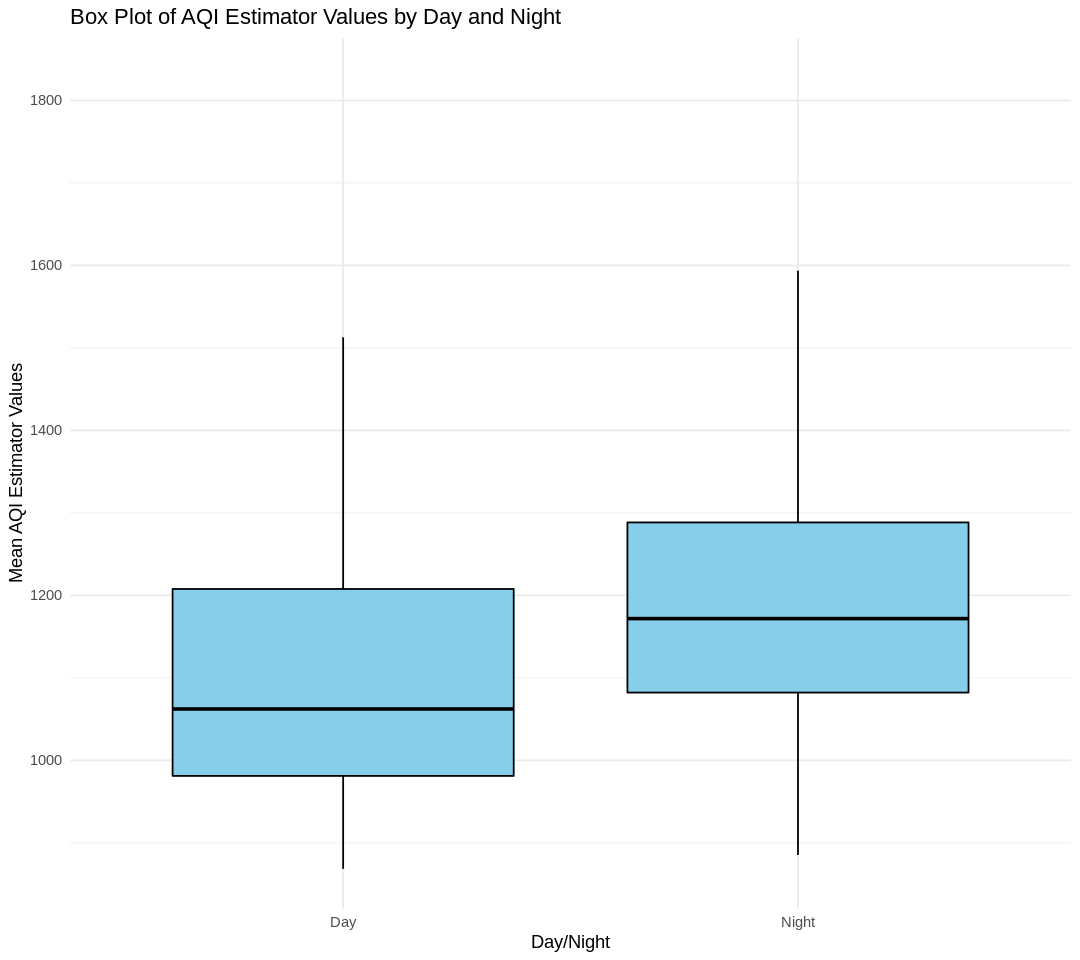

In [9]:
set.seed(1111)

# Create a box plot
boxplot <- ggplot(air_quality_final, aes(x = Day_Night, y = AQI_Estimator)) +
  geom_boxplot(fill = "skyblue", color = "black", outlier.shape = NA) +
  labs(title = "Box Plot of AQI Estimator Values by Day and Night",
       x = "Day/Night",
       y = "Mean AQI Estimator Values") +
  theme_minimal()

print(boxplot)

<p style="text-align: center;"><b><i>Plot 3:</b> Box Plot of AQI Estimator Values by Day and Night</i></p>

Similar to before, we create a dataset of summary statistics, this time using the AQI estimator values corresponding to day or night. 

In [10]:
set.seed(1111)

# Group the data by "Day_Night" and calculate the mean, median, standard deviation, and quartiles of "AQI_Estimator"
stats_by_day_night <- air_quality_final %>%
  group_by(Day_Night) %>%
  summarize(
    AQI_Estimator_Mean = mean(AQI_Estimator, na.rm = TRUE),
    AQI_Estimator_Median = median(AQI_Estimator, na.rm = TRUE),
    AQI_Estimator_SD = sd(AQI_Estimator, na.rm = TRUE),
    AQI_Estimator_Q1 = quantile(AQI_Estimator, 0.25, na.rm = TRUE),
    AQI_Estimator_Q3 = quantile(AQI_Estimator, 0.75, na.rm = TRUE)
  )

# Print the tibble
stats_by_day_night

Day_Night,AQI_Estimator_Mean,AQI_Estimator_Median,AQI_Estimator_SD,AQI_Estimator_Q1,AQI_Estimator_Q3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Day,1113.375,1062.2,175.2413,981.1,1207.7
Night,1194.423,1171.8,164.2705,1082.1,1288.4


<p style="text-align: center;"><b><i>Table 5.1:</b> Summary Statistics of AQI Estimator by Day and Night</i></p>

The next plots are distributions of the AQI estimator values according to time. We calculate the mean and median of day and night, then use built in functions (```ggplot()```, ```geom_histogram()```, ```geom_vline()```) to create four histograms (two timeframes for both the mean and median distributions) with marked values for the means and medians of each. 

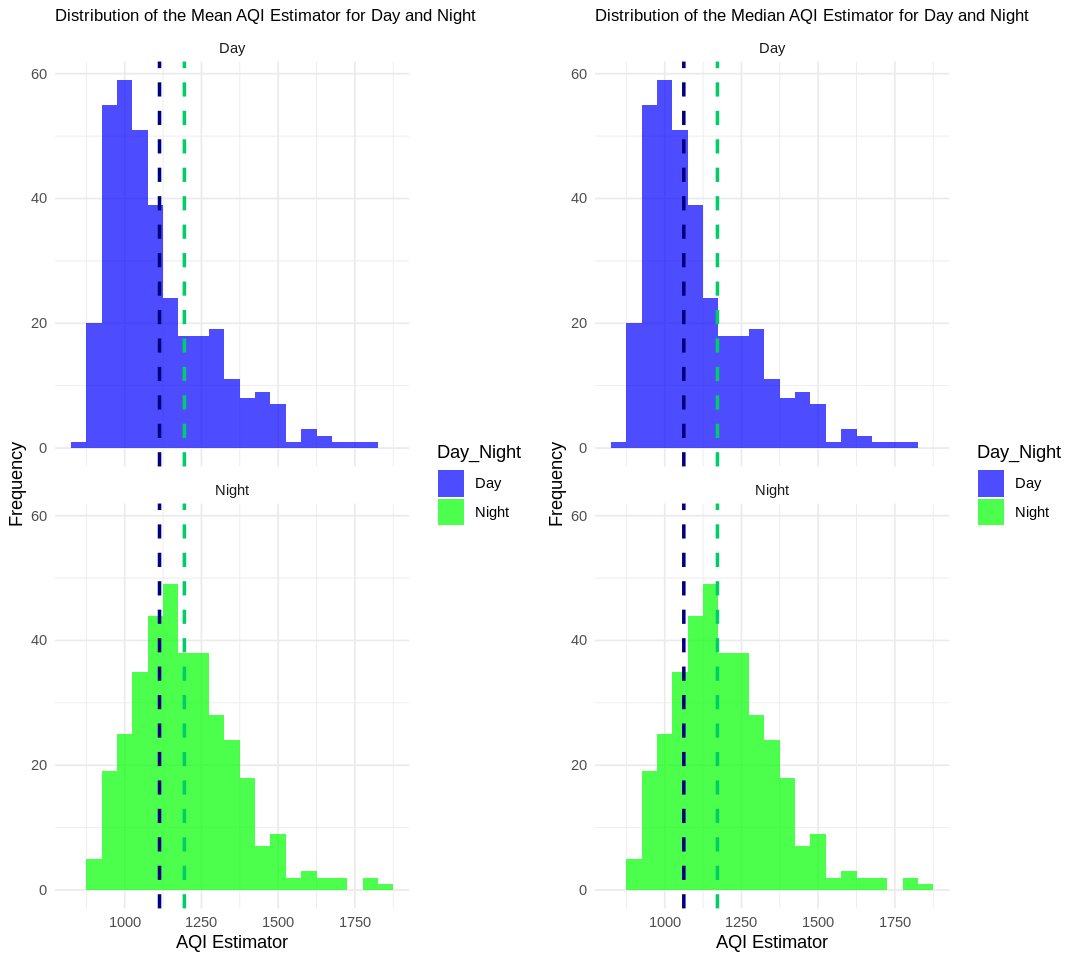

In [11]:
set.seed(1111)

# Calculate the means for Day and Night
mean_day <- mean(air_quality_final$AQI_Estimator[air_quality_final$Day_Night == "Day"], na.rm = TRUE)
mean_night <- mean(air_quality_final$AQI_Estimator[air_quality_final$Day_Night == "Night"], na.rm = TRUE)

## Plot for the Distribution of AQI Estimator for Day and Night
mean_plot <- ggplot(air_quality_final, aes(x = AQI_Estimator, fill = Day_Night)) +
  geom_histogram(binwidth = 50, position = "dodge", alpha = 0.7) +
  geom_vline(xintercept = mean_day, linetype = "dashed", color = "navyblue", size = 1) +
  geom_vline(xintercept = mean_night, linetype = "dashed", color = "springgreen3", size = 1) +
  labs(title = "Distribution of the Mean AQI Estimator for Day and Night",
       x = "AQI Estimator",
       y = "Frequency") +
  scale_x_continuous(breaks = seq(0, 2500, by = 250)) +
  scale_fill_manual(values = c("Day" = "blue", "Night" = "green")) +
  theme_minimal() +
  theme(plot.title = element_text(size = 10)) +
  facet_wrap(~Day_Night, ncol = 1)

# Calculate the medians for Day and Night
median_day <- median(air_quality_final$AQI_Estimator[air_quality_final$Day_Night == "Day"], na.rm = TRUE)
median_night <- median(air_quality_final$AQI_Estimator[air_quality_final$Day_Night == "Night"], na.rm = TRUE)

## Plot for the Distribution of AQI Estimator for Day and Night (Median)
median_plot <- ggplot(air_quality_final, aes(x = AQI_Estimator, fill = Day_Night)) +
  geom_histogram(binwidth = 50, position = "dodge", alpha = 0.7) +
  geom_vline(xintercept = median_day, linetype = "dashed", color = "navyblue", size = 1) +
  geom_vline(xintercept = median_night, linetype = "dashed", color = "springgreen3", size = 1) +
  labs(title = "Distribution of the Median AQI Estimator for Day and Night",
       x = "AQI Estimator",
       y = "Frequency") +
  scale_x_continuous(breaks = seq(0, 2500, by = 250)) +
  scale_fill_manual(values = c("Day" = "blue", "Night" = "green")) +
  theme_minimal() +
  theme(plot.title = element_text(size = 10)) +
  facet_wrap(~Day_Night, ncol = 1)


# Arrange plots side by side
grid.arrange(mean_plot, median_plot, ncol = 2)

<p style="text-align: center;"><b><i>Plot 4:</b> Distribution of AQI Estimator for Day and Night</i></p>

Our above findings show that the mean and median AQI Estimator is higher in the night than the day, implying that air quality is worse in the night.

## 3. Methods and Results

Our preliminary report can be considered trustworthy as it is pre-processed from a reputable dataset from the UCI machine learning repository, with any missing entries removed to ensure reliable results presented as plots and estimates. However, this may not be sufficient for stakeholders who require more evidence. So, we aim to complement the plots with hypothesis testing and confidence intervals to make inferences about the population parameters with a certain level of confidence.

**Proposed Plan:**

We will conduct **two hypothesis tests** to compare the average and median AQI estimator values between day and night. For the means, the null hypothesis (H<sub>0</sub>) would be that there is no significant difference in the mean AQI estimator values during day and night, while the alternative hypothesis (H<sub>A</sub>) would be that a significant difference exists. A similar hypothesis test will be performed to assess a difference in medians, with the null hypothesis (H<sub>0</sub>) being that there is no significant difference in the median AQI estimator values during day and night, and the alternative hypothesis (H<sub>A</sub>) being that a significant difference exists. To conduct our hypothesis tests we will be using the explanatory variable of the time of day (day vs night) in order to observe our response variable (air quality). This is to ensure consistency and corroborate our findings regarding air quality in the Italian city, and eliminate vagueness in our results.

We chose the explanatory variable because there may be underlying environmental causes for differences in air quality during time of day. Moreover, the air quality may differ in the day or night due to properties in the air, causing it to hold more/less chemicals, resulting in higher/lower air quality.

We chose a **5% significance level** since this is a common value used in other studies on air quality and is widely applicable in our present research (Jelili, M. O. et al., (2020); Zhao, X. et al., (2018)). Furthermore, this will give a more accurate result as opposed to a larger/smaller significance level that would increase chances of making a Type I or Type II error.

We also construct **confidence intervals** (using a confidence level of 95%) for the summarized sensor response during day and night separately, to obtain a range of plausible values for the population mean and median, providing a measure of uncertainty around our estimates.

**Expected Results:**

Although our preliminary research showed otherwise, we expect to find that air quality is worse in the day. Based on previous research, the highest concentrations of different chemical pollutants occur in the day, likely due to traffic density, road dust, or temperature inversions (Chen et al., 2015).

**Calculating Test Statistics from Summary Statistics:**

To begin our research, we calculate the summary statistics for day and night. We calculate the test statistic (using the formula for a paired t-test), the degrees of freedom, and the p-value using the ```pt()``` function.

In [12]:
# Calculate summary statistics for each Day_Night group
air_quality_summary <- 
  air_quality_final %>% 
  filter(!is.na(AQI_Estimator)) %>% 
  group_by(Day_Night) %>% 
  summarise(sample_mean = mean(AQI_Estimator), 
            sample_median = median(AQI_Estimator),
            sample_var = var(AQI_Estimator),
            sample_sd = sd(AQI_Estimator),
            n = n())

# Print the summary statistics
head(air_quality_summary)

Day_Night,sample_mean,sample_median,sample_var,sample_sd,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Day,1113.375,1062.2,30709.53,175.2413,348
Night,1194.423,1171.8,26984.79,164.2705,351


<p style="text-align: left;"><b><i>Table 5.2:</b> Summary Statistics of AQI Estimator by Day and Night</i></p>

In [33]:
# Calculate the t-statistic for the paired t-test
t_statistic <- 
  (air_quality_summary$sample_mean[2] - air_quality_summary$sample_mean[1]) /
  sqrt(air_quality_summary$sample_var[2] / air_quality_summary$n[2] +
       air_quality_summary$sample_var[1] / air_quality_summary$n[1])

# Print the calculated t-statistic
cat("Calculated t-statistic:", t_statistic, "\n\n")

# Calculate the degrees of freedom approximation
df_approx <- air_quality_summary$n[1] + air_quality_summary$n[2] - 2

# Calculate the p-value using the cumulative distribution function (CDF) of the t-distribution
p_value <- 2 * pt(abs(t_statistic), df_approx, lower.tail = FALSE)

# Print the calculated p-value
cat("Calculated p-value:", p_value, "\n\n")

# Calculate the critical value for a 95% confidence interval
alpha <- 0.05
critical_value <- qnorm(1 - alpha / 2)

# Calculate the standard error of the difference in means
se_diff_means <- sqrt((air_quality_summary$sample_var[2] / air_quality_summary$n[2]) +
                      (air_quality_summary$sample_var[1] / air_quality_summary$n[1]))

# Calculate the margin of error for the confidence interval
margin_of_error <- critical_value * se_diff_means

# Calculate the confidence interval lower and upper bounds
ci_lower <- (air_quality_summary$sample_mean[1] - air_quality_summary$sample_mean[2]) - margin_of_error
ci_upper <- (air_quality_summary$sample_mean[1] - air_quality_summary$sample_mean[2]) + margin_of_error

ci_stat <- tibble(ci_lower, ci_upper)
ci_stat

Calculated t-statistic: 6.307186 

Calculated p-value: 5.046529e-10 



ci_lower,ci_upper
<dbl>,<dbl>
-106.2338,-55.86231


Our calculated test statistic is 6.30718551712858, while the p-value is 5.04652923636584*e^-10.

**Performing a Two-sample T-test:**

We subset the data according to time and conduct a two-sample t-test using ```t.test()``` and make sure to use ```tidy()``` for a clean result. 

In [34]:
set.seed(1111)

# Subset the data into day and night observations
morning_data <- air_quality_final %>%
  filter(Day_Night == "Day")

night_data <- air_quality_final %>%
  filter(Day_Night == "Night")


# Perform a two-sample t-test
t_test_result <- tidy(t.test(morning_data$AQI_Estimator, night_data$AQI_Estimator))

# Print the results
t_test_result

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-81.04807,1113.375,1194.423,-6.307186,5.061496e-10,693.2915,-106.2779,-55.81826,Welch Two Sample t-test,two.sided


<p style="text-align: center;"><b><i>Table 6:</b> Results of Two-Sample t-test </i></p>

The p value calculated by our t-test is consistent with our previous value of 5.04652923636584*e^-10.

### Hypothesis Test #1: Difference in Means

**Calculating the Difference of Means:**

First in our hypothesis testing is finding a difference in the means of the AQI Estimator values for day and night. We calculate the mean AQI estimator value for day and night, using ```group_by()``` and ```summarize()```, then ```pivot_wider()``` to separate the day and night means. We calculate difference, using ```transmute()```, between the night and day values, in that order, and pull that value. 

In [36]:
# Calculate the mean AQI_Estimator for each Day_Night group
obs_mean_aqi_diff <- 
    air_quality_final %>% 
    group_by(Day_Night) %>% 
    summarise(mean = mean(AQI_Estimator)) %>%

    # Pivot the data to have Day and Night mean AQI in separate columns
    pivot_wider(names_from = Day_Night, values_from = mean) %>%
    
    # Calculate the difference between Night and Day mean AQI
    transmute(diff = Night - Day) %>%
    
    # Extract the calculated differences into a vector
    pull(diff)

# Display the calculated differences
cat("Observed Median Difference between Night and Day:", obs_mean_aqi_diff, "\n\n")

Observed Median Difference between Night and Day: 81.04807 



**Creating a Null Model:**

We create a null model for our AQI estimator values using the ```infer``` package. We specify our formula using the explanatory and response variables, then hypothesize using the null. Lastly, we generate our replications and note the type, and then calculate the difference in means for each replicate. 

In [16]:
# Set the seed for reproducibility
set.seed(1111)

# Create a null model for AQI_Estimator based on Day_Night categories
null_model_aqi <- 
    air_quality_final %>% 
    
    # Define the formula for the null model
    specify(formula = AQI_Estimator ~ Day_Night) %>% 
    
    # Specify the null hypothesis as independence between variables
    hypothesize(null = "independence") %>% 
    
    # Generate permutations of the data
    generate(reps = 1000, type = "permute") %>% 
    
    # Calculate the statistic (difference in means) for each permutation
    calculate(stat = "diff in means", order = c("Night", "Day"))

# Display the first few rows of the calculated null model statistics
head(null_model_aqi)


replicate,stat
<int>,<dbl>
1,-6.527788
2,-27.329315
3,16.704686
4,19.135632
5,-19.299411
6,10.285112


<p style="text-align: left;"><b><i>Table 7:</b> Calculated Null-Model Difference in Means </i></p>

**Finding and Visualizing the Confidence Interval:**

To compare different methods (bootstrap vs asymptotic), we calculate the confidence interval for the difference in AQI estimator values, using ```get_confidence_interval()```. We visualize the AQI differences, using ```visualize()```, shading the previously cacluated confidence interval.

lower_ci,upper_ci
<dbl>,<dbl>
-25.52842,24.88953


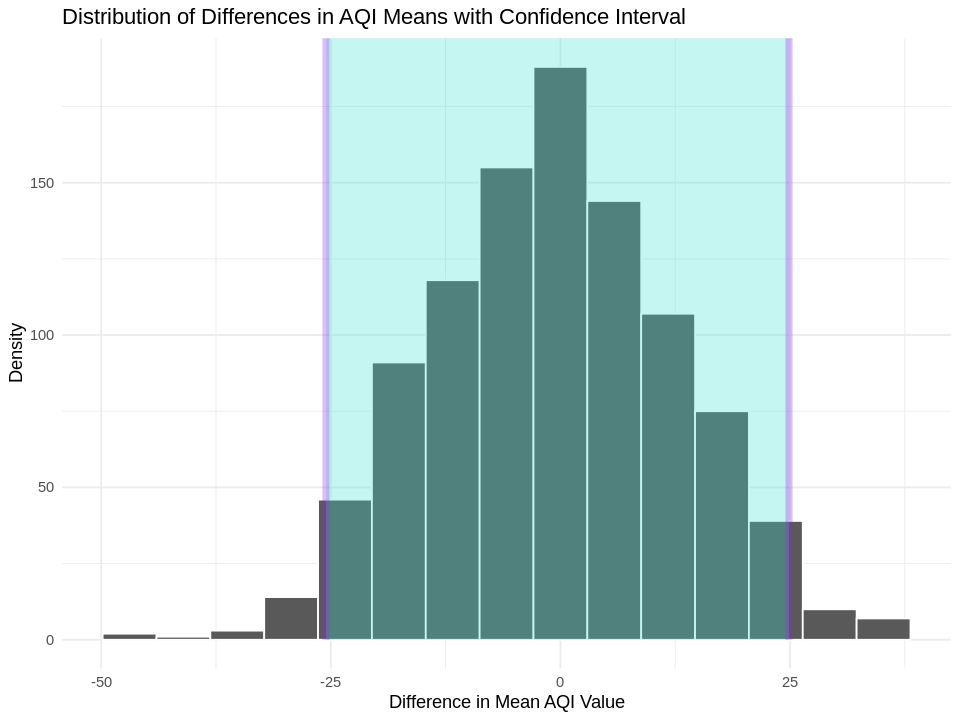

In [17]:
# Resize the plot
options(repr.plot.width = 8, repr.plot.height = 6)

# Calculate the confidence interval for AQI differences
aqi_confidence_interval <- null_model_aqi %>%
    get_confidence_interval(level = 0.95)

# Display the calculated confidence interval
aqi_confidence_interval

# Visualize the results of the null model for AQI differences
aqi_confidence_plot <- null_model_aqi %>%
    visualize() +
    theme_minimal() +                # Set a clean and minimal theme
    labs(
        title = "Distribution of Differences in AQI Means with Confidence Interval",
        x = "Difference in Mean AQI Value",
        y = "Density"
    ) +
    shade_confidence_interval(
        color = "purple",             # Choose a color for the shaded region
        alpha = 0.3,                   # Adjust transparency of the shaded region
        endpoints = aqi_confidence_interval  # Use calculated confidence interval endpoints
    )

# Display the improved plot
aqi_confidence_plot


<p style="text-align: center;"><b><i>Plot 5:</b> Distribution of Differences in AQI Means with Confidence Interval </i></p>

We find that about 95% of our 95% confidence intervals capture the true difference of the mean AQI values in the night and day, in that order, between the bounds of -25.52842 and 24.88953.

**Visualizing the Difference of Means:**

We visualize the results of the null model using ```visualize()```, shading the p-value. We calculate the p-value using the bootstrap distribution and the observed difference of means. 

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


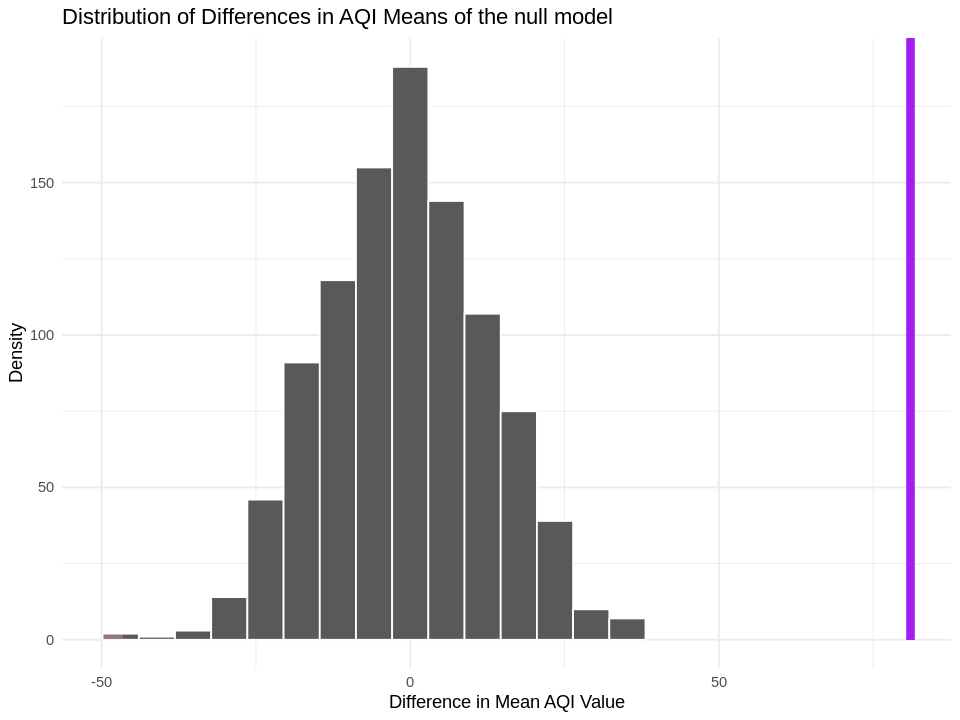

In [18]:
# Resize the plot
options(repr.plot.width = 8, repr.plot.height = 6)

# Visualize the results of the null model for AQI differences
aqi_result_plot <- null_model_aqi %>%
    visualize() +
    theme_minimal() +                # Set a clean and minimal theme
    labs(
        title = "Distribution of Differences in AQI Means of the null model",
        x = "Difference in Mean AQI Value",
        y = "Density"
    ) +
    shade_p_value(
        obs_stat = obs_mean_aqi_diff,
        direction = "both",
        color = "purple",             # Choose a distinct color for the shaded region
        alpha = 0.3                   # Adjust transparency of the shaded region
    )

# Display the improved plot
aqi_result_plot


# Calculate the p-value using the bootstrap distribution of null model statistics
p_value_bootstrap <- null_model_aqi %>%
    get_p_value(obs_stat = obs_mean_aqi_diff, direction = "both")

# Display the calculated p-value
p_value_bootstrap

<p style="text-align: center;"><b><i>Plot 6:</b> Distribution of Differences in AQI Means of the null model</i></p>

Reporting a p-value of exactly 0 is bad practice as it implies that there is no scope for the null hypothesis ever being true. So, we instead report this p-value as < 0.001, since we generated it using 1000 reps. This p-value is in line with our asymptotic p-value of 5.04652923636584*e^-10.

### Hypothesis Test #2: Difference in Medians

In [19]:
# Printing the first few observations of the dataset
head(air_quality_final)

,Day_Night,AQI_Estimator
,<chr>,<dbl>
1,Night,1284.4
2,Night,1190.4
3,Night,1222.0
4,Night,1240.6
5,Night,1182.6
6,Night,1125.2


<p style="text-align: left;"><b><i>Table 4:</b> Computed AQI Estimates for our observations</i></p>

**Calculating the Median AQI Difference:**

We calculate the median AQI estimator values for day and night using ```group_by()``` and ```summarize()```, then compute the difference in medians of the values between night and day, in that order, using ```transmute()```.

In [20]:
# Calculate the median AQI_Estimator for each Day_Night group
obs_median_aqi_diff <- 
    air_quality_final %>% 
    group_by(Day_Night) %>% 
    summarise(median = median(AQI_Estimator)) %>%

    # Pivot the data to have Day and Night median AQI in separate columns
    pivot_wider(names_from = Day_Night, values_from = median) %>%
    
    # Calculate the difference between Night and Day median AQI
    transmute(diff = Night - Day) %>%
    
    # Extract the calculated differences into a vector
    pull(diff)

# Display the calculated differences
obs_median_aqi_diff

[1] 109.6

We find that the median AQI during the night is 109.6 units higher than during the day. This indicates a potential pattern of higher AQI levels at night compared to day.

**Creating the Null Model:**

This follows the same steps as the creation of our null model for the computation of the difference of means, but here we compute the difference in medians instead.

In [21]:
# Create a null model for AQI_Estimator based on Day_Night categories
null_model_median_aqi <- 
    air_quality_final %>% 
    
    # Define the formula for the null model
    specify(formula = AQI_Estimator ~ Day_Night) %>% 
    
    # Specify the null hypothesis as independence between variables
    hypothesize(null = "independence") %>% 
    
    # Generate permutations of the data
    generate(reps = 1000, type = "permute") %>% 
    
    # Calculate the statistic (difference in medians) for each permutation
    calculate(stat = "diff in medians", order = c("Night", "Day"))

# Display the first few rows of the calculated null model statistics
head(null_model_median_aqi)


replicate,stat
<int>,<dbl>
1,-1.5
2,16.2
3,19.1
4,2.4
5,14.9
6,-18.6


<p style="text-align: left;"><b><i>Table 8:</b> Calculated Null-Model Difference in Medians </i></p>

lower_ci,upper_ci
<dbl>,<dbl>
-31.1,32.91


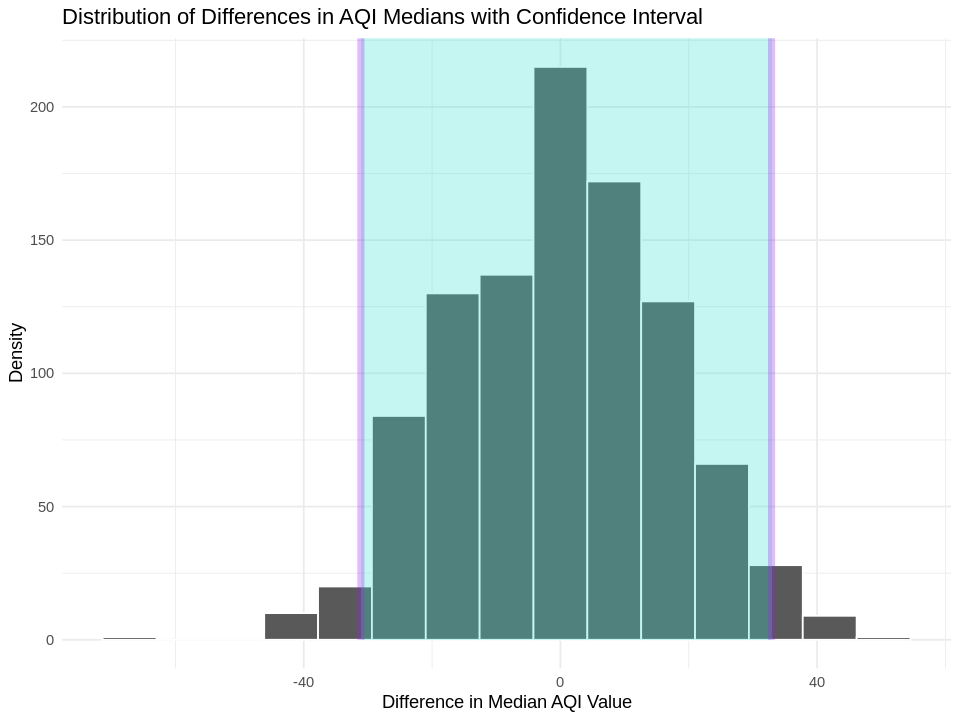

In [22]:
# Calculate the confidence interval for AQI differences
aqi_median_confidence_interval <- null_model_median_aqi %>%
    get_confidence_interval(level = 0.95)

# Display the calculated confidence interval
aqi_median_confidence_interval

# Visualize the results of the null model for AQI differences
aqi_median_confidence_plot <- null_model_median_aqi %>%
    visualize() +
    theme_minimal() +                # Set a clean and minimal theme
    labs(
        title = "Distribution of Differences in AQI Medians with Confidence Interval",
        x = "Difference in Median AQI Value",
        y = "Density"
    ) +
    shade_confidence_interval(
        color = "purple",             # Choose a color for the shaded region
        alpha = 0.3,                   # Adjust transparency of the shaded region
        endpoints = aqi_median_confidence_interval  # Use calculated confidence interval endpoints
    )

# Display the improved plot
aqi_median_confidence_plot

<p style="text-align: center;"><b><i>Plot 7:</b> Distribution of Differences in AQI Medians with 95% Confidence Interval</i></p>

A 95% confidence interval was calculated for the differences in AQI medians between the night and day. The confidence interval ranges from approximately -31.1 to 32.91 AQI estimator units. This interval suggests that with 95% confidence, the true difference in AQI medians between night and day falls within this range. This indicates that there is no clear evidence of a significant difference in AQI medians between the two time categories, as the confidence interval spans both positive and negative values.

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


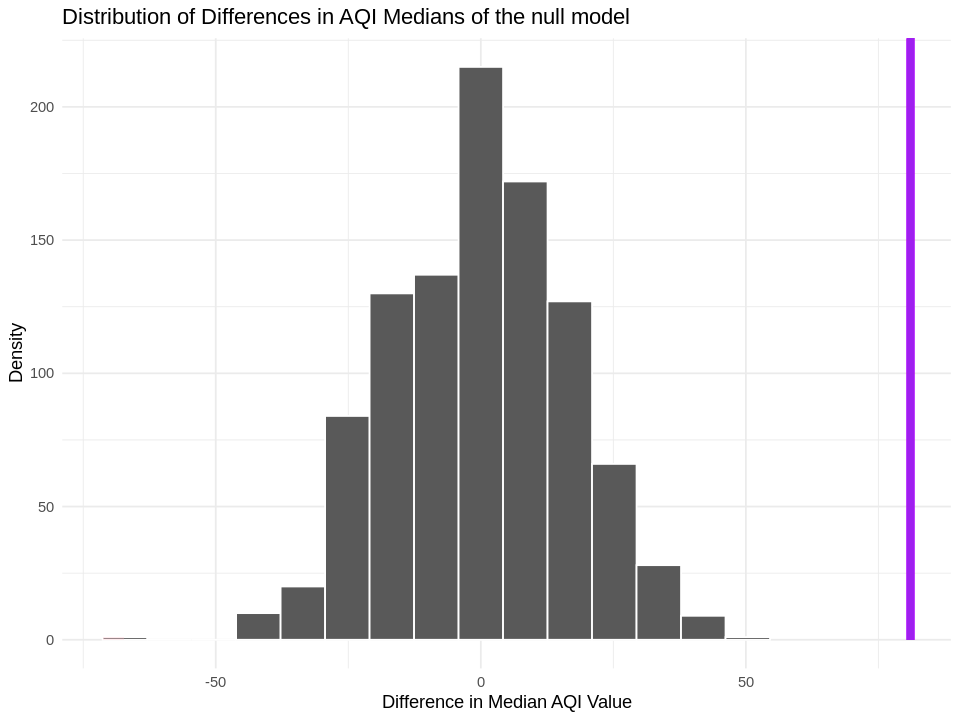

In [23]:
# Resize the plot
options(repr.plot.width = 8, repr.plot.height = 6)

# Visualize the results of the null model for AQI differences
aqi_median_result_plot <- null_model_median_aqi %>%
    visualize() +
    theme_minimal() +                # Set a clean and minimal theme
    labs(
        title = "Distribution of Differences in AQI Medians of the null model",
        x = "Difference in Median AQI Value",
        y = "Density"
    ) +
    shade_p_value(
        obs_stat = obs_mean_aqi_diff,
        direction = "both",
        color = "purple",             # Choose a distinct color for the shaded region
        alpha = 0.3                   # Adjust transparency of the shaded region
    )

# Display the improved plot
aqi_median_result_plot


# Calculate the p-value using the bootstrap distribution of null model statistics
p_value_median_bootstrap <- null_model_median_aqi %>%
    get_p_value(obs_stat = obs_median_aqi_diff, direction = "both")

# Display the calculated p-value
p_value_median_bootstrap

<p style="text-align: center;"><b><i>Plot 8:</b> Distribution of Differences in AQI Medians of the null model</i></p>

**Summary of Visualization and p-value Calculation:**

Using the null model results, we visualize the distribution of differences in AQI medians between night and day. The plot displays a density distribution, showing the variability of AQI median differences under the null hypothesis of independence. The observed median AQI difference calculated from the data was shaded.

The calculated p-value from the bootstrap distribution of null model statistics is less than 0.001. This extremely low p-value suggests that the observed median AQI difference of approximately 109.6 is significantly different from what would be expected under the assumption of independence. This provides strong evidence to reject the null hypothesis and suggests that there is a statistically significant difference in median AQI values between night and day.

### Results:

After we did the paired t-tests for day and night AQI Estimator values, the p-value was 5.04652923636584e-10. This was reinforced by our p-values from the bootstrap distribution of null model statistics for the difference in both means and medians, both being less than 0.001. This gives us a strong incentive to reject the null hypothesis (no significant difference in the mean or median AQI estimator values), in favour of the alternative hypothesis (significant differences in both the mean and the median AQI estimator values). We observed that the summarized AQI estimator values were higher in the night than the day, implying that air quality was worse at night in this Italian city. The mean AQI estimator value was 81.04807 units higher in the night than day, while the median AQI estimator was 109.6 units higher in the night than day.

**Bootstrapping vs. Asymptotics:**

Both bootstrapping and asymptotic methods gave us similar results for our p-value, being extremely close to 0. We find using the asymptotics method to yield more specific results, as the resulting p-value of 5.04652923636584e-10 is extremely precise. As mentioned earlier, the p-value of 0 obtained through bootstrapping enforces the assumption that there is no room for *not* rejecting our null hypothesis, which is ill-practice. Also, larger sample sizes inherently lead to more precise estimates of population parameters, and the asymptotic approach capitalizes on this. In our case, the relatively substantial dataset we employed further bolstered the precision of the p-value obtained through asymptotics. Asymptotics are a good fit for our p-value, while bootstrapping tends to underfit the true p-value (Ramses et al., 2020).

**Effect Size Consideration:**

In addition to evaluating statistical significance, it's crucial to consider the effect size of the observed differences in AQI estimator values. While our analysis indicates a statistically significant difference, quantifying the magnitude of this difference provides a deeper understanding of its practical implications. A larger effect size signifies a more substantial and potentially more meaningful difference in air quality between the two time periods. This consideration aids stakeholders in assessing the practical significance of our findings and their real-world impact on urban planning and public health policies.

## 4. Discussion

We expected to find that air quality would be worse during the day, based on research indicating different urban activities affect pollutants in the air. After conducting our hypothesis tests, we found that our results contradicted this, but was in line with our preliminary findings of air quality being worse at night.

**Implications and Further Research:**

The finding of this research could have implications for urban planning and public health policies. City and environmental agencies can use this information to implement interventions during specific times to improve air quality and protect health.

This could lead to further research on the long term health effects of exposure to poor air quality in cities. Additionally, one could explore the relationship between air quality and specific sources of pollution, like vehicular emissions or industrial activities. In conclusion, this comprehensive report aimed to shed light on the difference in air quality in an Italian city during days and nights. By incorporating hypothesis testing and confidence intervals, we can provide more robust evidence to stakeholders, facilitating informed decision-making and potential policy changes for healthier urban environments. The research findings could lead to further investigations and have a positive impact on public health and environmental management, particularly in curbing sources of air pollution in the night.

There are several potential reasons for the difference observed in the air qualities between night and day:
- The different conditions of atmospheric diffusion. There are different conditions of things like solar illumination, wind speed, and moderation in the day and night, which affect the AQI.
- Variations in traffic and industrial activities also contribute to the differences in AQI between day and night.

Though we measured a month's worth of data in our research, we can generalize this finding to the rest of the data and consider it a representative sample. Based on the tests we conducted on the difference in means and the difference in medians, overall we found that the air quality was worse in the **night** than in the day. Though both tests measured similar variables, we found this to be conducive to our research, as measuring the difference in medians after the difference in means provided further evidence in support of our initial result.

## 5. References

Chen, W., Tang, H., & Zhao, H. (2015). Diurnal, weekly and monthly spatial variations of air pollutants and air  quality of Beijing. Atmospheric Environment, 119, 21-34. https://doi.org/10.1016/j.atmosenv.2015.08.040

Jelili, M. O., Gbadegesin, A. S., & Alabi, A. T. (2020). Comparative Analysis of Indoor and Outdoor Particulate Matter Concentrations and Air Quality in Ogbomoso, Nigeria. Journal of health & pollution, 10(28), 201205. https://doi.org/10.5696/2156-9614-10.28.201205

Lemeš, S. (2018). Air Quality Index (AQI) - Comparative Study and Assessment of an Appropriate Model for B&H. 12th Scientific/Research Symposium with International Participation. 

Ramses, A.N., Stapenhurst, C., & Yalonetzky, G. (2020). Asymptotic Versus Bootstrap Inference for Inequality Indices of the Cumulative Distribution Function. Econometrics, 8(1). https://doi.org/10.3390/econometrics8010008

Trozzi, C.,  Vaccaro, R., & Crocetti, S. (1999). Air quality index and its use in Italy’s management plans. Science of the Total Environment. 235(1-3),387-389. https://doi.org/10.1016/S0048-9697(99)00242-9

Zhao, X., Gao, Q., Sun, M., Xue, Y., Ma, R., Xiao, X., & Ai, B. (2018). Statistical Analysis of Spatiotemporal Heterogeneity of the Distribution of Air Quality and Dominant Air Pollutants and the Effect Factors in Qingdao Urban Zones. Atmosphere, 9(4), 135. MDPI AG. http://dx.doi.org/10.3390/atmos9040135
